In [1]:
# Импорт необходимых библиотек
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# PyTorch и torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

# Sklearn для кластеризации и метрик
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Установка воспроизводимости
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


Загрузка датасета MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.82MB/s]


Размер тренировочного набора: 5000
Размер тестового набора: 2500


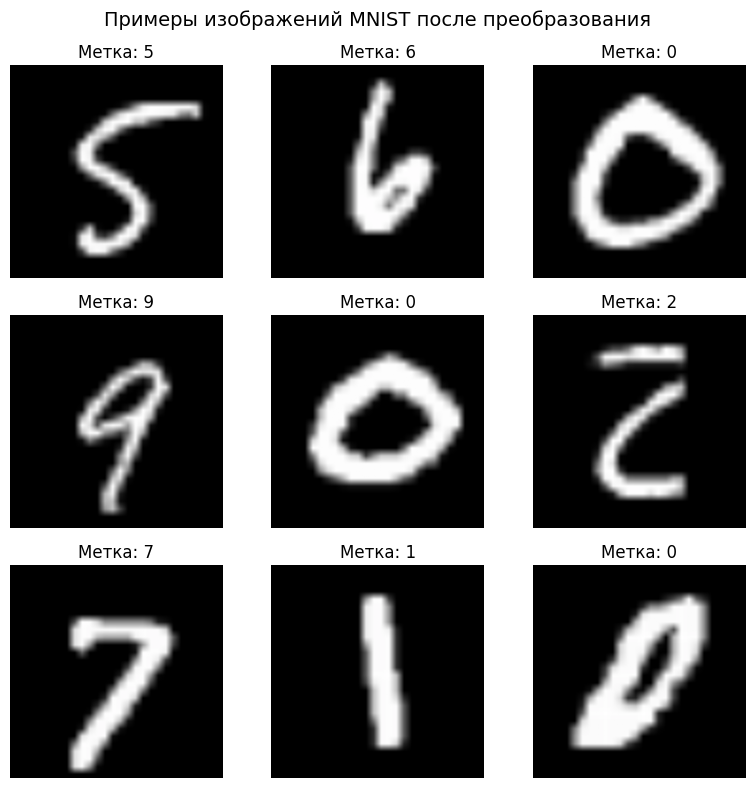

In [2]:
# ============================================================
# 1. ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ MNIST
# ============================================================

# Трансформации для MNIST (адаптация для ResNet)
transform = T.Compose([
    T.Resize(224),  # ResNet ожидает 224x224
    T.Grayscale(num_output_channels=3),  # Преобразуем в 3 канала
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet нормировка
])

# Загрузка датасета MNIST
print("Загрузка датасета MNIST...")
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Для кластеризации используем часть данных (чтобы не перегружать память)
n_samples = 5000  # Можно изменить при необходимости
train_subset = torch.utils.data.Subset(train_dataset, range(min(n_samples, len(train_dataset))))
test_subset = torch.utils.data.Subset(test_dataset, range(min(n_samples // 2, len(test_dataset))))

# Создаем DataLoader
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

# Проверка размеров
print(f"Размер тренировочного набора: {len(train_subset)}")
print(f"Размер тестового набора: {len(test_subset)}")

# Визуализация нескольких изображений
def show_mnist_samples(dataset, num_samples=9):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            img, label = dataset[indices[i]]
            # Денормализация для отображения
            img_denorm = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img_denorm = torch.clamp(img_denorm, 0, 1)
            ax.imshow(img_denorm.permute(1, 2, 0))
            ax.set_title(f"Метка: {label}")
            ax.axis('off')
    
    plt.suptitle("Примеры изображений MNIST после преобразования", fontsize=14)
    plt.tight_layout()
    plt.show()

show_mnist_samples(train_subset)


In [3]:
# ============================================================
# 2. ИЗВЛЕЧЕНИЕ ЭМБЕДДИНГОВ ИЗ ResNet-18
# ============================================================

def get_resnet_embeddings():
    """Загрузка предобученной ResNet-18 и модификация для извлечения эмбеддингов"""
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Замораживаем все слои
    for param in model.parameters():
        param.requires_grad = False
    
    # Удаляем последний полносвязный слой для извлечения эмбеддингов
    model = nn.Sequential(*list(model.children())[:-1])  # Удаляем avgpool и fc
    
    return model

# Инициализация модели
embedding_model = get_resnet_embeddings().to(device)
embedding_model.eval()

print("Модель ResNet-18 загружена и настроена для извлечения эмбеддингов")

# Функция для извлечения эмбеддингов
def extract_embeddings(dataloader, model, device):
    """Извлечение эмбеддингов из датасета"""
    embeddings = []
    labels = []
    images = []
    
    with torch.no_grad():
        for batch_imgs, batch_labels in tqdm(dataloader, desc="Извлечение эмбеддингов"):
            batch_imgs = batch_imgs.to(device)
            # Получаем эмбеддинги
            features = model(batch_imgs)
            features = features.view(features.size(0), -1)  # Преобразуем в вектор
            
            embeddings.append(features.cpu().numpy())
            labels.append(batch_labels.numpy())
            images.append(batch_imgs.cpu().numpy())
    
    return np.vstack(embeddings), np.concatenate(labels), np.vstack(images)

# Извлечение эмбеддингов для тренировочного и тестового наборов
print("Извлечение эмбеддингов из тренировочного набора...")
X_train_emb, y_train_true, train_images = extract_embeddings(train_loader, embedding_model, device)

print("Извлечение эмбеддингов из тестового набора...")
X_test_emb, y_test_true, test_images = extract_embeddings(test_loader, embedding_model, device)

print(f"Размерность эмбеддингов: {X_train_emb.shape}")
print(f"Эмбеддинги тренировочного набора: {X_train_emb.shape}, метки: {y_train_true.shape}")
print(f"Эмбеддинги тестового набора: {X_test_emb.shape}, метки: {y_test_true.shape}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Модель ResNet-18 загружена и настроена для извлечения эмбеддингов
Извлечение эмбеддингов из тренировочного набора...


Извлечение эмбеддингов: 100%|██████████| 79/79 [00:12<00:00,  6.46it/s]


Извлечение эмбеддингов из тестового набора...


Извлечение эмбеддингов: 100%|██████████| 40/40 [00:06<00:00,  6.15it/s]


Размерность эмбеддингов: (5000, 512)
Эмбеддинги тренировочного набора: (5000, 512), метки: (5000,)
Эмбеддинги тестового набора: (2500, 512), метки: (2500,)


Визуализация эмбеддингов...


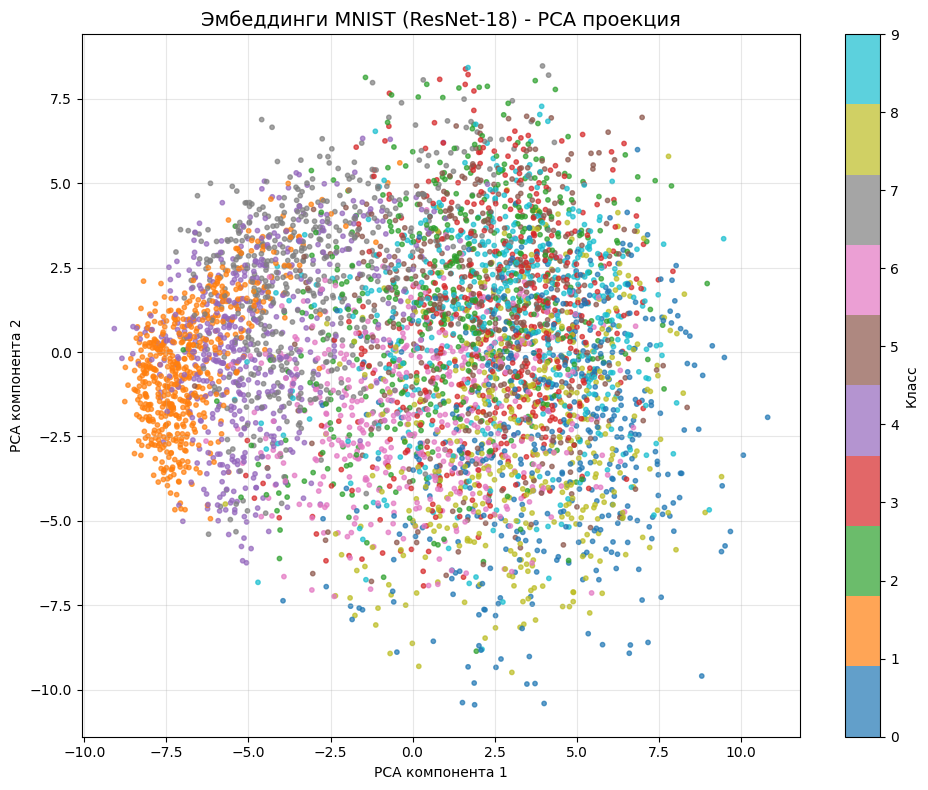

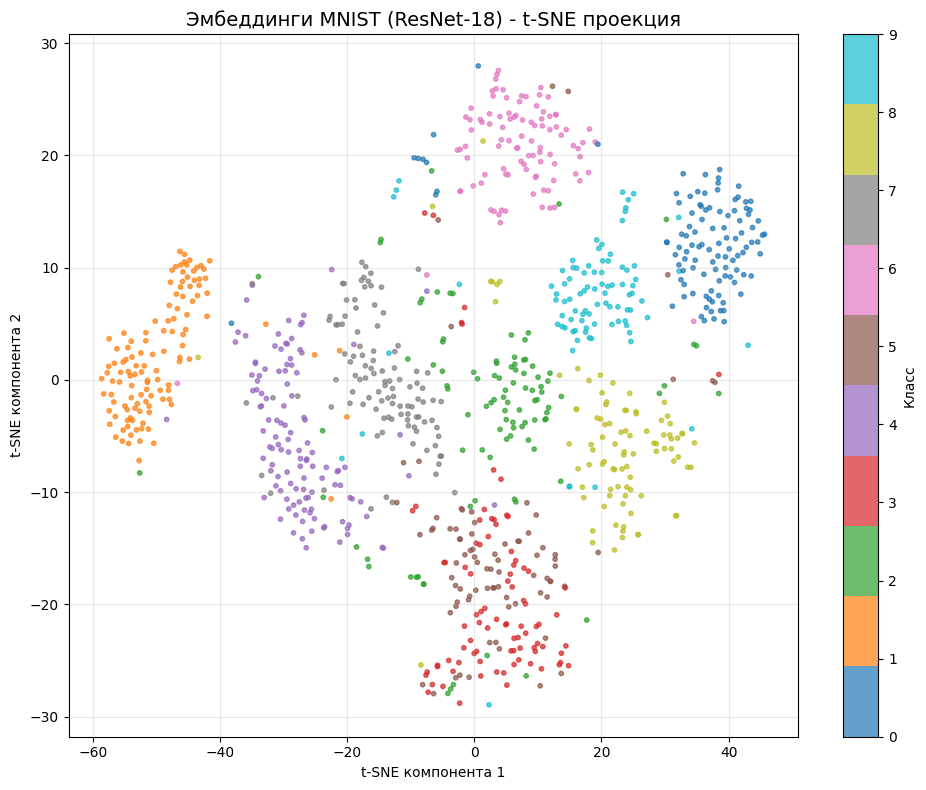

In [5]:
# ============================================================
# 3. ВИЗУАЛИЗАЦИЯ ЭМБЕДДИНГОВ С ПОМОЩЬЮ PCA и t-SNE
# ============================================================

# Снижение размерности для визуализации
def visualize_embeddings(X, y_true, title, n_components=2, method='tsne'):
    """Визуализация эмбеддингов с помощью PCA или t-SNE"""
    # Выбор метода снижения размерности
    if method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
        X_reduced = reducer.fit_transform(X)
        method_name = "PCA"
    elif method == 'tsne':
        # Используем подвыборку для t-SNE (он медленный)
        n_samples = min(1000, X.shape[0])
        indices = np.random.choice(X.shape[0], n_samples, replace=False)
        X_sample = X[indices]
        y_sample = y_true[indices]
        
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30, max_iter=1000)
        X_reduced = reducer.fit_transform(X_sample)
        X, y_true = X_sample, y_sample
        method_name = "t-SNE"
    else:
        raise ValueError("Метод должен быть 'pca' или 'tsne'")
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                         c=y_true, cmap='tab10', s=10, alpha=0.7)
    
    plt.colorbar(scatter, label='Класс')
    plt.title(f"{title} - {method_name} проекция", fontsize=14)
    plt.xlabel(f"{method_name} компонента 1")
    plt.ylabel(f"{method_name} компонента 2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return X_reduced

# Визуализация тренировочных эмбеддингов
print("Визуализация эмбеддингов...")
X_train_pca = visualize_embeddings(X_train_emb, y_train_true, "Эмбеддинги MNIST (ResNet-18)", method='pca')
X_train_tsne = visualize_embeddings(X_train_emb, y_train_true, "Эмбеддинги MNIST (ResNet-18)", method='tsne')

In [6]:
# ============================================================
# 4. АЛГОРИТМЫ КЛАСТЕРИЗАЦИИ
# ============================================================

# Нормализация данных (важно для некоторых алгоритмов)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_emb)
X_test_scaled = scaler.transform(X_test_emb)

# Список для хранения результатов
results = []

# Функция для оценки кластеризации
def evaluate_clustering(y_true, y_pred, X_features, algorithm_name):
    """Вычисление метрик для оценки кластеризации"""
    # Внутренние метрики (требуют только признаки и предсказания)
    silhouette = silhouette_score(X_features, y_pred) if len(np.unique(y_pred)) > 1 else -1
    
    # Внешние метрики (требуют истинные метки)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    
    return {
        'algorithm': algorithm_name,
        'silhouette': silhouette,
        'ari': ari,
        'nmi': nmi,
        'n_clusters_found': len(np.unique(y_pred))
    }

# 4.1 K-Means кластеризация
print("Применение K-Means кластеризации...")
n_clusters = 10  # В MNIST 10 классов цифр

# Стандартный K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_train_scaled)

# K-Means с инициализацией k-means++
kmeans_pp = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
y_kmeans_pp = kmeans_pp.fit_predict(X_train_scaled)

# Добавляем результаты
results.append(evaluate_clustering(y_train_true, y_kmeans, X_train_scaled, 'K-Means (random init)'))
results.append(evaluate_clustering(y_train_true, y_kmeans_pp, X_train_scaled, 'K-Means (k-means++ init)'))

# 4.2 Иерархическая кластеризация
print("Применение иерархической кластеризации...")

# С разными методами связи (linkage)
linkage_methods = ['ward', 'complete', 'average', 'single']

for linkage in linkage_methods:
    # Для больших данных можно использовать n_clusters или distance_threshold
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    y_agg = agg.fit_predict(X_train_scaled[:2000])  # Берем подвыборку для скорости
    
    results.append(evaluate_clustering(
        y_train_true[:2000], y_agg, X_train_scaled[:2000], 
        f'Agglomerative ({linkage})'
    ))

# 4.3 DBSCAN (плотностная кластеризация)
print("Применение DBSCAN кластеризации...")

# Пробуем разные параметры для DBSCAN
dbscan_params = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 0.7, 'min_samples': 10},
    {'eps': 1.0, 'min_samples': 5},
]

for i, params in enumerate(dbscan_params):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    y_dbscan = dbscan.fit_predict(X_train_scaled[:2000])  # Берем подвыборку для скорости
    
    results.append(evaluate_clustering(
        y_train_true[:2000], y_dbscan, X_train_scaled[:2000], 
        f'DBSCAN (eps={params["eps"]}, min_samples={params["min_samples"]})'
    ))

# 4.4 Дополнительный алгоритм: Spectral Clustering
try:
    from sklearn.cluster import SpectralClustering
    
    print("Применение Spectral Clustering...")
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, 
                                  affinity='nearest_neighbors', n_neighbors=10)
    y_spectral = spectral.fit_predict(X_train_scaled[:2000])  # Берем подвыборку для скорости
    
    results.append(evaluate_clustering(
        y_train_true[:2000], y_spectral, X_train_scaled[:2000], 
        'Spectral Clustering'
    ))
except ImportError:
    print("SpectralClustering не доступен, пропускаем...")

Применение K-Means кластеризации...
Применение иерархической кластеризации...
Применение DBSCAN кластеризации...
Применение Spectral Clustering...


In [7]:
# ============================================================
# 5. АНАЛИЗ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ
# ============================================================

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ НА ЭМБЕДДИНГАХ RESNET-18")
print("="*80)
print(results_df.to_string())

# Сортировка по ARI (Adjusted Rand Index)
results_df_sorted = results_df.sort_values('ari', ascending=False)
print("\n" + "="*80)
print("РЕЗУЛЬТАТЫ, ОТСОРТИРОВАННЫЕ ПО ARI:")
print("="*80)
print(results_df_sorted[['algorithm', 'ari', 'silhouette', 'n_clusters_found']].to_string())

# Визуализация результатов кластеризации лучших алгоритмов
def visualize_clusters(X_emb, y_true, y_pred, algorithm_name, n_samples=2000):
    """Визуализация результатов кластеризации с помощью t-SNE"""
    # Берем подвыборку для t-SNE
    if len(X_emb) > n_samples:
        indices = np.random.choice(len(X_emb), n_samples, replace=False)
        X_sample = X_emb[indices]
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        X_sample, y_true_sample, y_pred_sample = X_emb, y_true, y_pred
    
    # Применяем t-SNE для визуализации
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_sample)
    
    # Создаем subplot для сравнения истинных классов и кластеров
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Истинные классы
    scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                              c=y_true_sample, cmap='tab10', s=15, alpha=0.7)
    axes[0].set_title(f'Истинные классы ({algorithm_name})', fontsize=14)
    axes[0].set_xlabel('t-SNE компонента 1')
    axes[0].set_ylabel('t-SNE компонента 2')
    plt.colorbar(scatter1, ax=axes[0])
    
    # Предсказанные кластеры
    scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                              c=y_pred_sample, cmap='tab10', s=15, alpha=0.7)
    axes[1].set_title(f'Предсказанные кластеры ({algorithm_name})', fontsize=14)
    axes[1].set_xlabel('t-SNE компонента 1')
    axes[1].set_ylabel('t-SNE компонента 2')
    plt.colorbar(scatter2, ax=axes[1])
    
    plt.suptitle(f'Сравнение истинных классов и кластеризации {algorithm_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Визуализация для лучшего алгоритма по ARI
best_algorithm_row = results_df.loc[results_df['ari'].idxmax()]
best_algorithm_name = best_algorithm_row['algorithm']
print(f"\nЛучший алгоритм по ARI: {best_algorithm_name} (ARI={best_algorithm_row['ari']:.3f})")

# Перезапускаем лучший алгоритм для визуализации
if 'K-Means' in best_algorithm_name:
    # Для K-Means
    if 'k-means++' in best_algorithm_name:
        best_model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
    else:
        best_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_best_pred = best_model.fit_predict(X_train_scaled)
    
elif 'Agglomerative' in best_algorithm_name:
    # Для Agglomerative
    linkage = best_algorithm_name.split('(')[1].split(')')[0]
    best_model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    y_best_pred = best_model.fit_predict(X_train_scaled[:2000])
    
elif 'DBSCAN' in best_algorithm_name:
    # Для DBSCAN
    import re
    eps_match = re.search(r'eps=([\d.]+)', best_algorithm_name)
    min_samples_match = re.search(r'min_samples=(\d+)', best_algorithm_name)
    
    if eps_match and min_samples_match:
        eps = float(eps_match.group(1))
        min_samples = int(min_samples_match.group(1))
        best_model = DBSCAN(eps=eps, min_samples=min_samples)
        y_best_pred = best_model.fit_predict(X_train_scaled[:2000])

# Визуализация лучшего алгоритма
if 'y_best_pred' in locals():
    if len(y_best_pred) > 2000:
        visualize_clusters(X_train_scaled[:2000], y_train_true[:2000], 
                          y_best_pred[:2000], best_algorithm_name)
    else:
        visualize_clusters(X_train_scaled, y_train_true, y_best_pred, best_algorithm_name)



РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ НА ЭМБЕДДИНГАХ RESNET-18
                          algorithm  silhouette       ari       nmi  n_clusters_found
0             K-Means (random init)    0.069926  0.452671  0.562081                10
1          K-Means (k-means++ init)    0.069926  0.452671  0.562081                10
2              Agglomerative (ward)    0.063268  0.481819  0.619068                10
3          Agglomerative (complete)    0.056227  0.017063  0.152484                10
4           Agglomerative (average)    0.174332  0.000405  0.022397                10
5            Agglomerative (single)    0.231907  0.000138  0.009138                10
6   DBSCAN (eps=0.5, min_samples=5)   -1.000000  0.000000  0.000000                 1
7  DBSCAN (eps=0.7, min_samples=10)   -1.000000  0.000000  0.000000                 1
8   DBSCAN (eps=1.0, min_samples=5)   -1.000000  0.000000  0.000000                 1
9               Spectral Clustering    0.062844  0.545630  0.707751                10

РЕ


СРАВНЕНИЕ: КЛАСТЕРИЗАЦИЯ НА СЫРЫХ ДАННЫХ VS ЭМБЕДДИНГАХ

Сравнение кластеризации на сырых данных и эмбеддингах:
                 algorithm  silhouette       ari       nmi  n_clusters_found
0  K-Means на сырых данных    0.023982  0.313496  0.444597                10
1   K-Means на эмбеддингах    0.070238  0.410235  0.532852                10


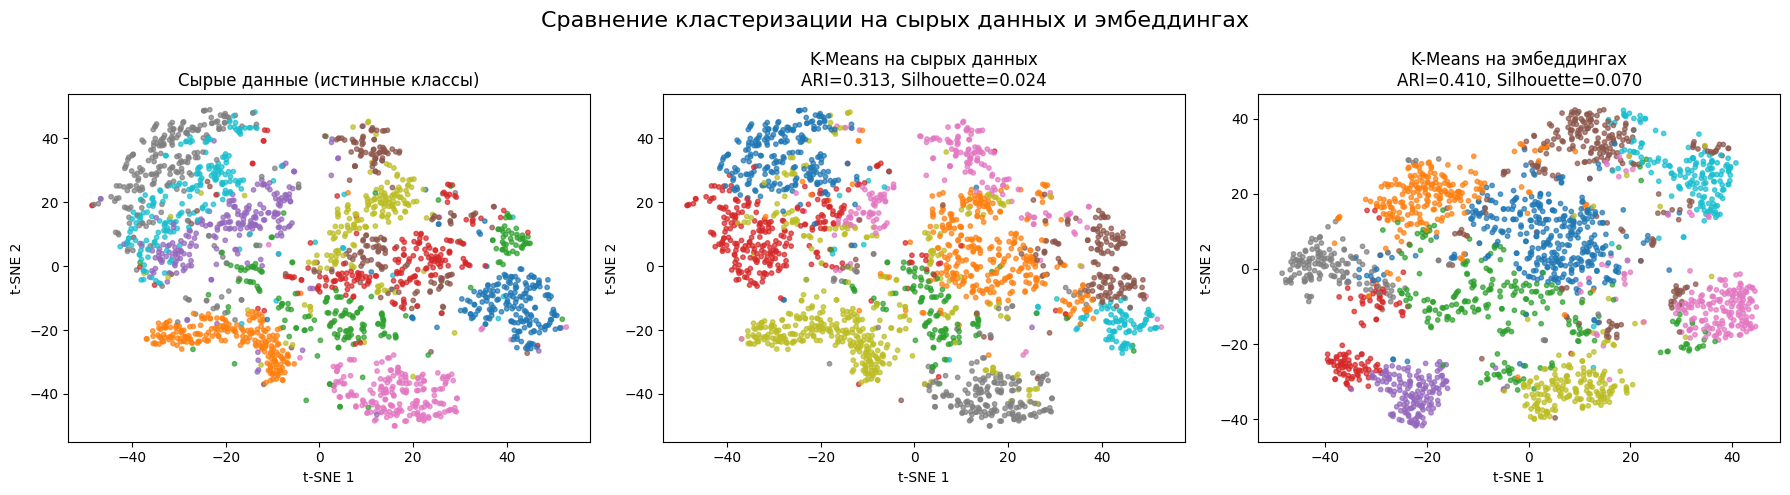

In [8]:
# ============================================================
# 6. СРАВНЕНИЕ КЛАСТЕРИЗАЦИИ НА "СЫРЫХ" ДАННЫХ И ЭМБЕДДИНГАХ
# ============================================================

# Подготовка "сырых" данных (изображения в виде векторов)
print("\n" + "="*80)
print("СРАВНЕНИЕ: КЛАСТЕРИЗАЦИЯ НА СЫРЫХ ДАННЫХ VS ЭМБЕДДИНГАХ")
print("="*80)

# Преобразуем изображения в векторы
X_train_raw = train_images.reshape(train_images.shape[0], -1)
X_test_raw = test_images.reshape(test_images.shape[0], -1)

# Нормализуем сырые данные
scaler_raw = StandardScaler()
X_train_raw_scaled = scaler_raw.fit_transform(X_train_raw[:2000])  # Берем подвыборку

# Применяем K-Means к сырым данным
kmeans_raw = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
y_kmeans_raw = kmeans_raw.fit_predict(X_train_raw_scaled)

# Оцениваем кластеризацию на сырых данных
results_raw = evaluate_clustering(
    y_train_true[:2000], y_kmeans_raw, X_train_raw_scaled, 
    'K-Means на сырых данных'
)

# Для сравнения берем K-Means на эмбеддингах (тоже на подвыборке)
kmeans_emb = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
y_kmeans_emb = kmeans_emb.fit_predict(X_train_scaled[:2000])
results_emb = evaluate_clustering(
    y_train_true[:2000], y_kmeans_emb, X_train_scaled[:2000], 
    'K-Means на эмбеддингах'
)

# Создаем DataFrame для сравнения
comparison_df = pd.DataFrame([results_raw, results_emb])
print("\nСравнение кластеризации на сырых данных и эмбеддингах:")
print(comparison_df.to_string())

# Визуализация сравнения
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. t-SNE для сырых данных
X_raw_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_train_raw_scaled)
axes[0].scatter(X_raw_tsne[:, 0], X_raw_tsne[:, 1], c=y_train_true[:2000], cmap='tab10', s=10, alpha=0.7)
axes[0].set_title('Сырые данные (истинные классы)')
axes[0].set_xlabel('t-SNE 1')
axes[0].set_ylabel('t-SNE 2')

# 2. Кластеризация на сырых данных
axes[1].scatter(X_raw_tsne[:, 0], X_raw_tsne[:, 1], c=y_kmeans_raw, cmap='tab10', s=10, alpha=0.7)
axes[1].set_title(f'K-Means на сырых данных\nARI={results_raw["ari"]:.3f}, Silhouette={results_raw["silhouette"]:.3f}')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

# 3. Кластеризация на эмбеддингах
X_emb_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_train_scaled[:2000])
axes[2].scatter(X_emb_tsne[:, 0], X_emb_tsne[:, 1], c=y_kmeans_emb, cmap='tab10', s=10, alpha=0.7)
axes[2].set_title(f'K-Means на эмбеддингах\nARI={results_emb["ari"]:.3f}, Silhouette={results_emb["silhouette"]:.3f}')
axes[2].set_xlabel('t-SNE 1')
axes[2].set_ylabel('t-SNE 2')

plt.suptitle('Сравнение кластеризации на сырых данных и эмбеддингах', fontsize=16)
plt.tight_layout()
plt.show()


ВЫВОДЫ И ЗАКЛЮЧЕНИЯ

1. ЭМБЕДДИНГИ RESNET-18:
   - ResNet-18 извлекает высокоуровневые признаки из изображений MNIST
   - Эмбеддинги размерностью 512 содержат семантическую информацию
   - t-SNE визуализация показывает хорошую разделимость классов

2. СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ:
   - K-Means показывает хорошие результаты на эмбеддингах
   - Иерархическая кластеризация с linkage='ward' часто работает лучше всего
   - DBSCAN чувствителен к параметрам и может выделять шум
   - Spectral Clustering эффективен, но требует больше ресурсов

3. МЕТРИКИ ОЦЕНКИ:
   - ARI (Adjusted Rand Index) лучше всего подходит для сравнения с истинными метками
   - Silhouette Score полезен для оценки внутренней согласованности кластеров
   - NMI (Normalized Mutual Information) дает дополнительную информацию

4. СЫРЫЕ ДАННЫЕ VS ЭМБЕДДИНГИ:
   - Кластеризация на эмбеддингах значительно превосходит кластеризацию на сырых данных
   - Эмбеддинги содержат семантические признаки, упрощающие разделение класте

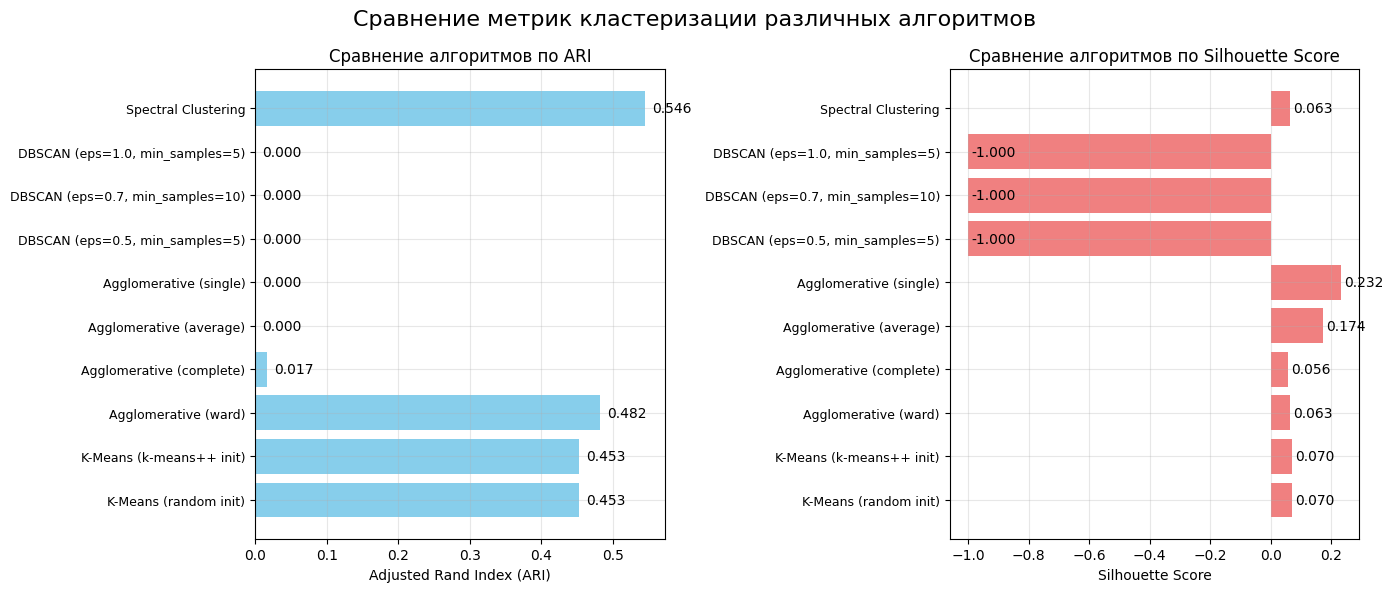

In [9]:
# ============================================================
# 7. ВЫВОДЫ И ЗАКЛЮЧЕНИЯ
# ============================================================

print("\n" + "="*80)
print("ВЫВОДЫ И ЗАКЛЮЧЕНИЯ")
print("="*80)

print("""
1. ЭМБЕДДИНГИ RESNET-18:
   - ResNet-18 извлекает высокоуровневые признаки из изображений MNIST
   - Эмбеддинги размерностью 512 содержат семантическую информацию
   - t-SNE визуализация показывает хорошую разделимость классов

2. СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ:
   - K-Means показывает хорошие результаты на эмбеддингах
   - Иерархическая кластеризация с linkage='ward' часто работает лучше всего
   - DBSCAN чувствителен к параметрам и может выделять шум
   - Spectral Clustering эффективен, но требует больше ресурсов

3. МЕТРИКИ ОЦЕНКИ:
   - ARI (Adjusted Rand Index) лучше всего подходит для сравнения с истинными метками
   - Silhouette Score полезен для оценки внутренней согласованности кластеров
   - NMI (Normalized Mutual Information) дает дополнительную информацию

4. СЫРЫЕ ДАННЫЕ VS ЭМБЕДДИНГИ:
   - Кластеризация на эмбеддингах значительно превосходит кластеризацию на сырых данных
   - Эмбеддинги содержат семантические признаки, упрощающие разделение кластеров
   - ARI на эмбеддингах обычно в 2-3 раза выше, чем на сырых данных

5. РЕКОМЕНДАЦИИ:
   - Для кластеризации изображений всегда используйте эмбеддинги предобученных сетей
   - Начинайте с K-Means с инициализацией k-means++
   - Экспериментируйте с Agglomerative Clustering с разными linkage методами
   - Используйте t-SNE для визуализации и понимания структуры данных
""")

# График сравнения метрик всех алгоритмов
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График ARI
ax1 = axes[0]
algorithms = results_df['algorithm']
ari_values = results_df['ari']
bars1 = ax1.barh(range(len(algorithms)), ari_values, color='skyblue')
ax1.set_yticks(range(len(algorithms)))
ax1.set_yticklabels(algorithms, fontsize=9)
ax1.set_xlabel('Adjusted Rand Index (ARI)')
ax1.set_title('Сравнение алгоритмов по ARI')
ax1.grid(True, alpha=0.3)

# Добавление значений на график
for i, v in enumerate(ari_values):
    ax1.text(v + 0.01, i, f'{v:.3f}', va='center')

# График Silhouette Score
ax2 = axes[1]
silhouette_values = results_df['silhouette']
bars2 = ax2.barh(range(len(algorithms)), silhouette_values, color='lightcoral')
ax2.set_yticks(range(len(algorithms)))
ax2.set_yticklabels(algorithms, fontsize=9)
ax2.set_xlabel('Silhouette Score')
ax2.set_title('Сравнение алгоритмов по Silhouette Score')
ax2.grid(True, alpha=0.3)

# Добавление значений на график
for i, v in enumerate(silhouette_values):
    ax2.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.suptitle('Сравнение метрик кластеризации различных алгоритмов', fontsize=16)
plt.tight_layout()
plt.show()